<a href="https://colab.research.google.com/github/hafilmr/LearningCodeTrainee/blob/main/Deep%20Learning%20CNN/CNN_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

We will be looking at how to implement CNN's in Tensor flow for airline passengers. This script will follow the same pattern as the previous scripts with three steps. We'll start with the ones that forecast, followed by an incremental, multi-step forecast. The third option will try is the multi output multi-step forecast.

## **Import Library**

GlobalMaxPooling1D, Conv1D, MaxPooling1D -> N x T x D -> For Time Series

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
!pip install -U scikit-learn

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

## **Import Data**

We will use the airline_passengers.csv dataset as usual

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



## **Read Data**

In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])

In [ ]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
# booelan series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

We're using the differencing time series as before, if you believe that this should work without differencing, you are welcome to try.


In [ ]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [ ]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
x = []
y = []
for t in range(len(series) - T):
  X = series[t:t+T]
  x.append(X)
  Y = series[t+T]
  y.append(Y)

x = np.array(x).reshape(-1, T, 1) # (-1, T, 1) -> (N x T x 1) -> (N x T x D)
y = np.array(y)
N = len(x)
print('x.shape', x.shape, 'y.shape', y.shape)

x.shape (133, 10, 1) y.shape (133,)


## **Split Data**

In [ ]:
xtrain, ytrain = x[:-Ntest], y[:-Ntest]
xtest, ytest = x[-Ntest:], y[-Ntest:]

## **Modelling using CNN (1D)**

In [ ]:
# CNN
i = Input(shape=(T, 1)) #input for time series
x = Conv1D(16, 3, activation='relu')(i) #Declare Conv1D layer with 16 feature maps and 3 size of kernel
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x) #Declare Conv1D layer with 32 feature maps and 3 size of kernel
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x) #output #1 output for 1-step forecast
model = Model(i, x)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 8, 16)             64        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 4, 16)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 33  

So what this does is it list each layer of your model and tells you the output shape of the data at each step, along with the number of parameters of the layer.
This will help you understand how your data is transformed as it goes through the neural network.

You can see that the model starts out as a `[(None, 10, 1)]`, meaning a length 10 time series with one dimension.
After doing `convolution`, it has a length of eight and 16 feature maps `(None, 8, 16)`.
Note that the time dimension is smaller because by default `Tensor-Flow` uses valid mode convolution. Since our `max_pool` has size `two (2)` the data shrinks by half. So it goes from eight to four.
After one more valid mode `convolution`, it becomes size `two (2)`.
We also specified a thirty two feature maps `(None, 2, 32)`.
At that point we use `global max pooling` and the time dimension disappears.
So we now have a feature vector of size` 32` this can be passed through regular dense layers.
And so after our final linear layer, our output has size one (1).

In [ ]:
model.compile(
    loss='mse',
    optimizer='adam'
)

In [ ]:
r = model.fit(
    xtrain,
    ytrain,
    epochs=100,
    validation_data=(xtest, ytest)
)

Epoch 1/100
4/4 [==============================] - 1s 58ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0097 - val_loss: 0.0105
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0091
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 9/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0086
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 11/100
4/4 [=

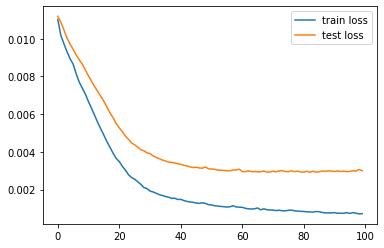

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

Loss Plot Report looks fine

**Set for Prediction**

In [ ]:
train_idx[:T+1] = False #first T+1 values are not predictable

In [ ]:
ptrain = model.predict(xtrain).flatten()
ptest = model.predict(xtest).flatten()

In [ ]:
# Store diff predictions
df.loc[train_idx, 'Diff Train Prediction'] = ptrain
df.loc[test_idx, 'Diff Test Prediction'] = ptest

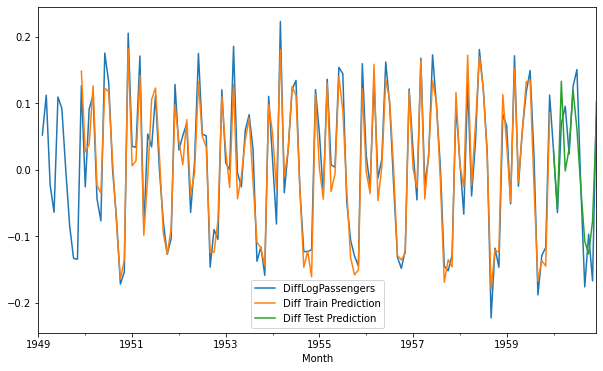

In [ ]:
cols = ['DiffLogPassengers',
        'Diff Train Prediction',
        'Diff Test Prediction']
df[cols].plot(figsize=(10, 6))

These are the `differenced (diff())`, one step predictions.

In [ ]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift()
prev = df['ShiftLogPassengers']

In [ ]:
# last-known train value
last_train = train.iloc[-1]['LogPassengers']

**1-Step (Un-Differenced) Forecast**

In [ ]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + ptest

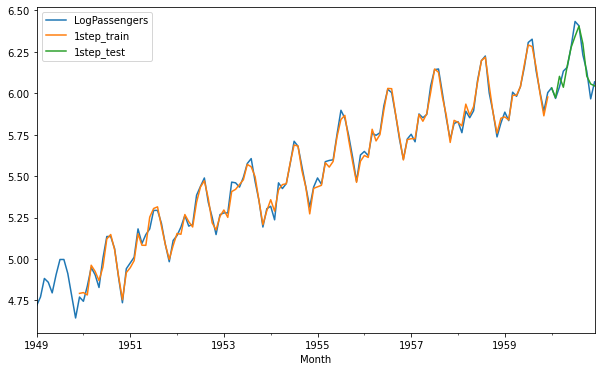

In [ ]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(10, 6));

This looks good, but we know whats the matter is `multi-step forecast`

**Multi-Step (Un-Differenced) Forecast**

In [ ]:
# multi-step forecast
multistep_predictions = []

# first test inpput
last_x = xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

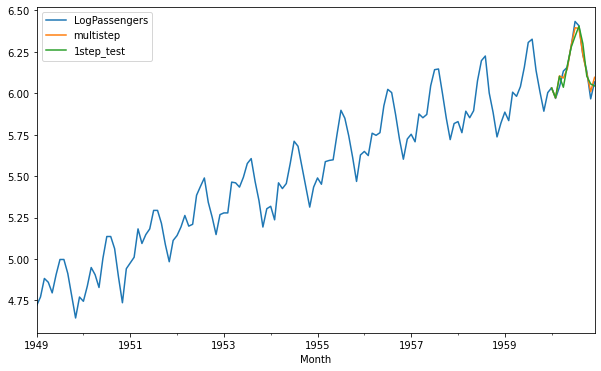

In [ ]:
# plot 1-step and multistep forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(10, 6))

It seems looks juts good, as 1-step forecast

**Multi-Output Forecast**

In [ ]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
x = []
y = []
for t in range(len(series) - Tx - Ty + 1):
  X = series[t:t+Tx]
  x.append(X)
  Y = series[t+Tx:t+Tx+Ty]
  y.append(Y)

x = np.array(x).reshape(-1, Tx, 1)
y = np.array(y).reshape(-1, Ty)
N = len(x)
print('x.shape', x.shape, 'y.shape', y.shape)

x.shape (122, 10, 1) y.shape (122, 12)


In [ ]:
xtrain_m, ytrain_m = x[:-1], y[:-1]
xtest_m, ytest_m = x[-1:], y[-1:]

In [ ]:
# CNN
i = Input(shape=(Tx, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x) #Ty as outputs
model = Model(i, x)

In [ ]:
model.compile(
    loss='mse',
    optimizer='adam'
)

In [ ]:
r = model.fit(
    xtrain_m,
    ytrain_m,
    epochs=200,
    validation_data=(xtest_m, ytest_m)
)

Epoch 1/200
4/4 [==============================] - 1s 81ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 2/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 3/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 4/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0107 - val_loss: 0.0113
Epoch 5/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 7/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 8/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 9/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 10/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 11/200
4/4 [=

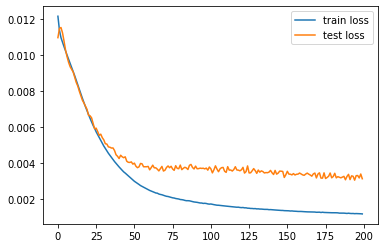

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
ptrain = model.predict(xtrain_m)
ptest = model.predict(xtest_m)

In [ ]:
ptrain.shape, ptest.shape

((121, 12), (1, 12))

In [ ]:
ptrain = ptrain[:,0]
ptest = ptest[0]

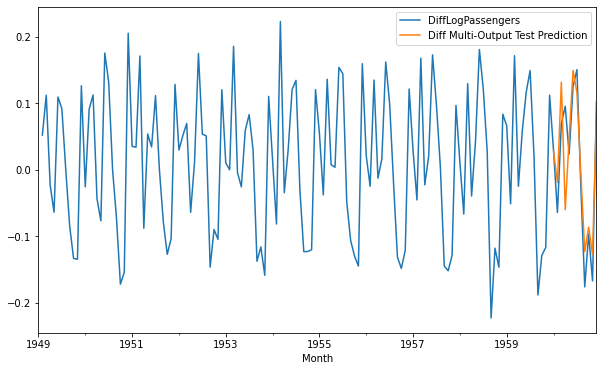

In [ ]:
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = ptest
cols = ['DiffLogPassengers', 'Diff Multi-Output Test Prediction']
df[cols].plot(figsize=(10, 6))

Multi-output predictions looks fine

In [ ]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(ptest)

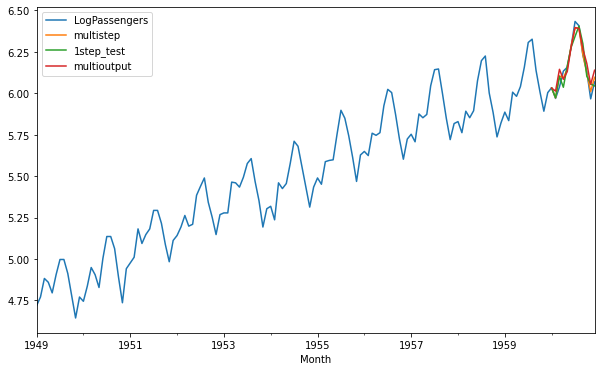

In [ ]:
# plot all forecast
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(10, 6))

In [ ]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print('multi-step MAPE:', mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print('multi-output MAPE:', mape2)

multi-step MAPE: 0.003642729631224577
multi-output MAPE: 0.007155414694696227


In [ ]:
# Exercise:
# Do you think differencing (diff()) is unnecesary? Try it!
# Do you think logging (np.log) is unnecesary? Try it!
# Do you think including more past lags would be useful?
# Have you consideren walk-forward validation to optimize hyperparameters?